# Modeling

The goal is to predict the expected value of the total claim amount per exposure unit (year).



- Model the number of claims with a Poisson distribution, and the average
   claim amount per claim, with a Gamma distribution.




In [64]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler,
    KBinsDiscretizer,
)

# Add parent directory to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from src.utils import replace_birthdate_with_age, load_data, plot_boxplots
from src.metrics import plot_obs_pred, score_estimator

## Data load and pre-processing

- load and preprocess data

In [ ]:
# load feature data
file_path = parent_dir / 'features.parquet'
df_feat = load_data(file_path)


# preprocess feature data
df_feat = df_feat[df_feat['Exposure'] > 0.2 ]
#df_feat = df_feat[df_feat['ClaimNb'] < 5]

df_feat = replace_birthdate_with_age(df_feat, 'BirthD', reference_date='2023-01-01')
df_feat['VehGas'] = df_feat['VehGas'].fillna('G3')
df_feat["Exposure"] = df_feat["Exposure"].clip(0.1, 1)
df_feat["ClaimNb"] = df_feat["ClaimNb"].clip(upper=4)
df_feat["DriverAge"] = df_feat["DriverAge"].clip(19, 85)
df_feat['VehAge'] = df_feat['VehAge'].clip(0, 20)
df_feat['BonusMalus'] = df_feat['BonusMalus'].clip(0, 100)

# load target data
file_path = parent_dir / 'target.parquet'
df_target = load_data(file_path)

# preprocess target data
df_target = df_target.groupby('IDpol', as_index=False).agg({'ClaimAmount': 'sum'})
df_target['ClaimAmount'] = df_target['ClaimAmount'].clip(0, 100000)

# merge feature and target data
df_feat["IDpol"] = df_feat["IDpol"].astype(int)
df_feat.set_index("IDpol", inplace=True)
df = pd.merge(df_feat, df_target, on='IDpol', how='left')

#df = df[(df['IDpol'] > 4000000) & (df['IDpol'] < 5000000)]
#df = df[df['ClaimNb'] > 0]

## feature and target definitions

- transform features



In [ ]:
# log-transform the target variable
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

# create a column transformer for preprocessing
column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=5, encode="ordinal"), ["VehAge", "DriverAge"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
transmored_features = column_trans.fit_transform(df)
########################################################

df["Claim_freq"] = df["ClaimNb"] / df["Exposure"]
df["Avg_claim_amount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)


## Model Claim frequency model

- The number of claims (``ClaimNb``) is a positive integer (0 included).
- discrete events occurring in a given time interval (``Exposure``) independent from each other.
- model the Claim frequency ``ClaimNb / Exposure`` and use ``Exposure`` as offset.



In [101]:
df_train, df_test, X_train, X_test = train_test_split(df, transmored_features, random_state=0)

# Fit a Poisson regression model for claim frequency
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=1000)
glm_freq.fit(X_train, df_train["Claim_freq"], sample_weight=df_train["Exposure"])

scores = score_estimator(glm_freq, X_train, X_test, df_train, df_test, target="Claim_freq", weights="Exposure")
print("Evaluation of PoissonRegressor on target Claim_freq")
print(scores)

Evaluation of PoissonRegressor on target Claim_freq
subset               train    test
metric                            
mean abs. error     0.1646  0.1647
mean squared error  0.1541  0.1532
square error score  0.0110  0.0091


- visualize the predictes values

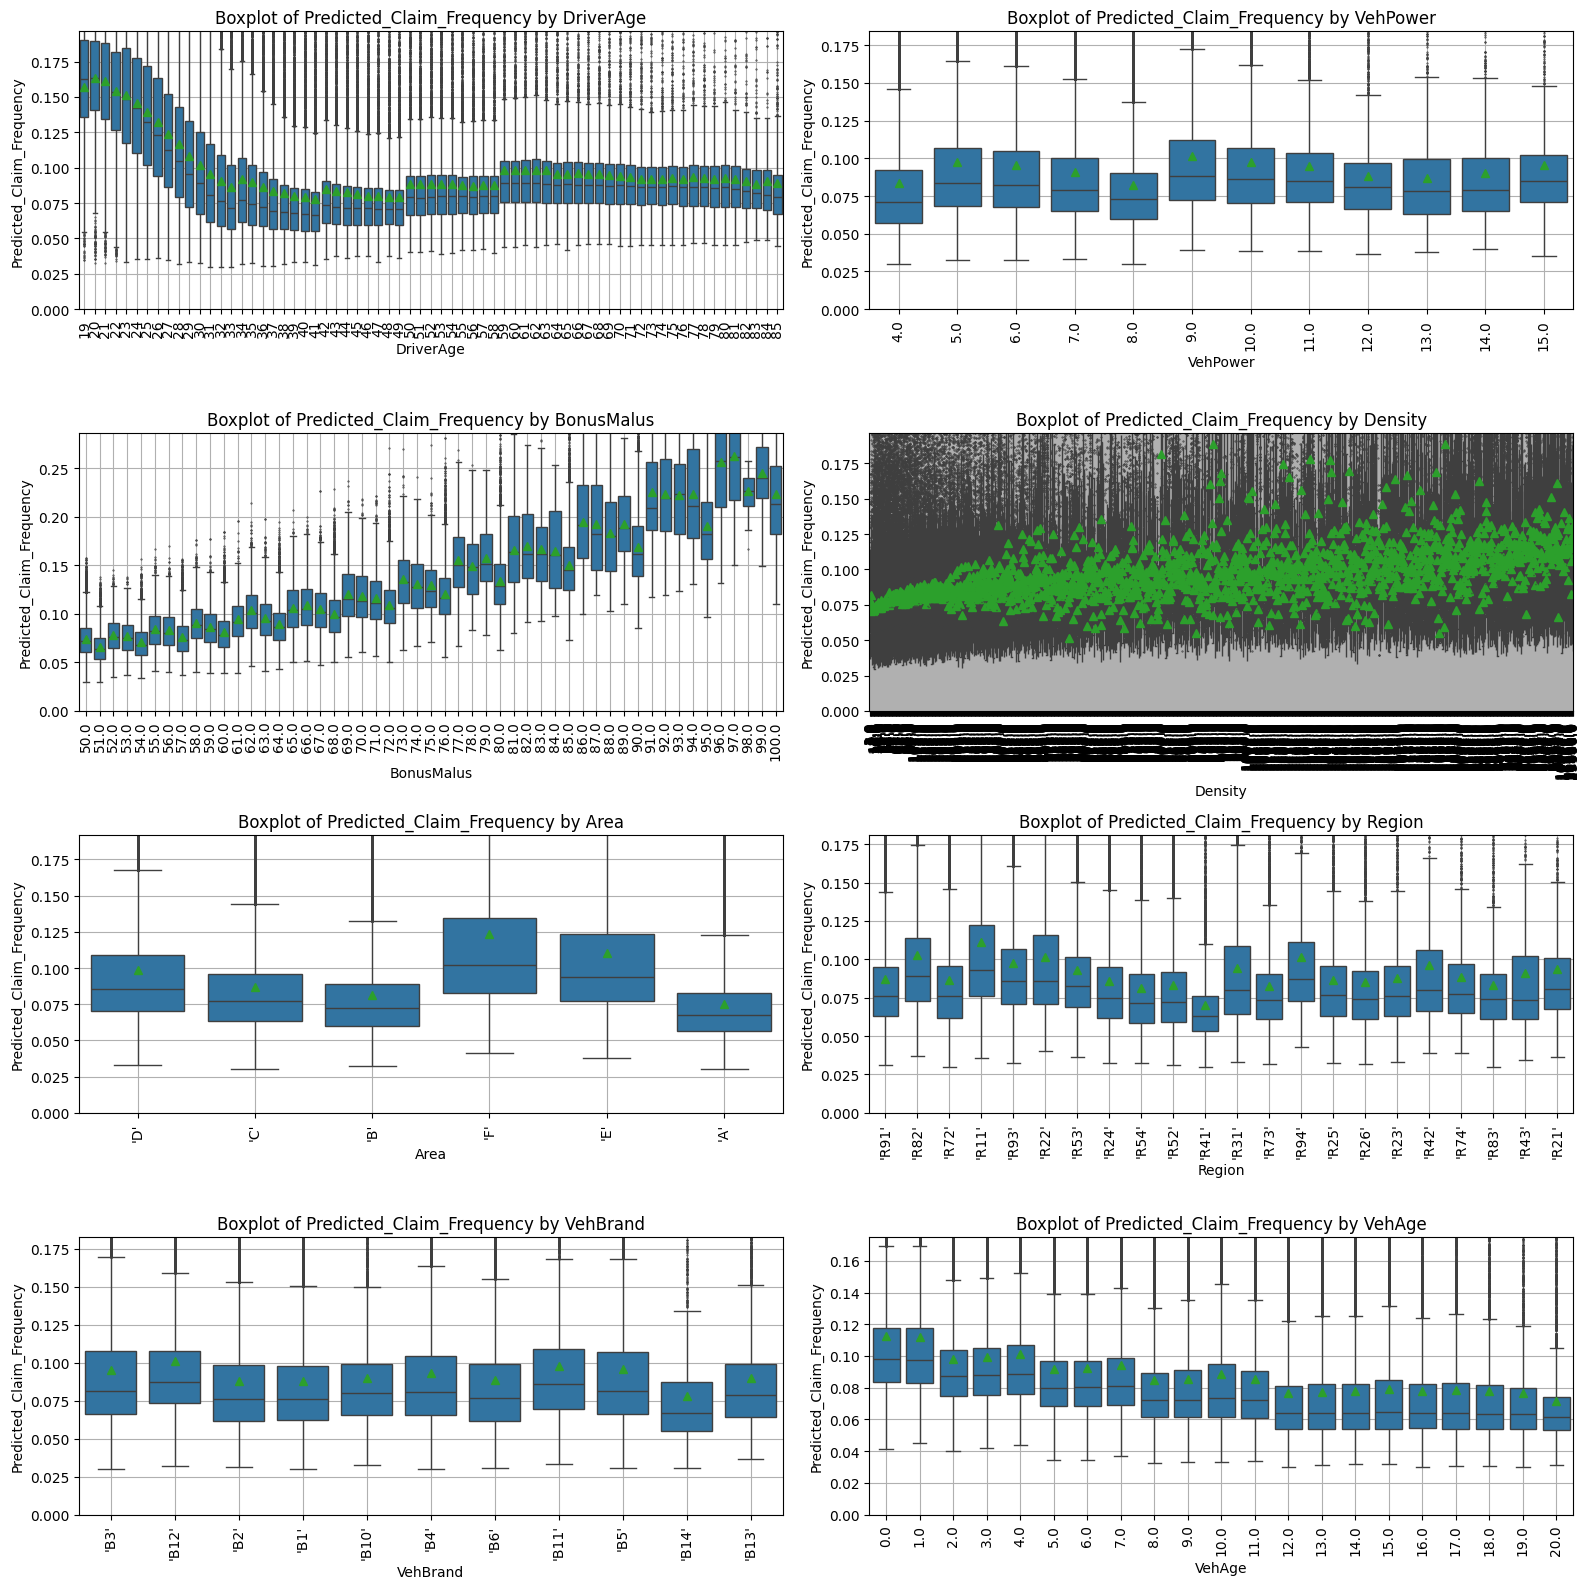

In [102]:
df_train["Predicted_Claim_Frequency"] = glm_freq.predict(X_train)
#print(df_train.head(10))

plot_boxplots(['DriverAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'Region', 'VehBrand', 'VehAge'], 'Predicted_Claim_Frequency', df_train)

- visulaize the scatter plot of observed and 

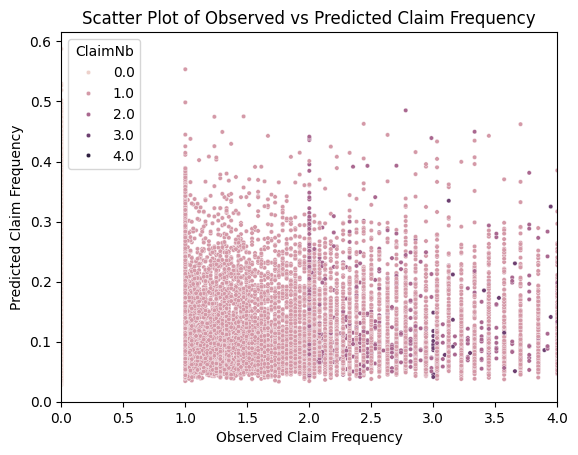

In [93]:
sns.scatterplot(
    x=df_train['Claim_freq'], 
    y=df_train['Predicted_Claim_Frequency'],
    hue=df_train['ClaimNb'],
    s=10  # Set marker size to be smaller
)
plt.xlabel('Observed Claim Frequency')
plt.ylabel('Predicted Claim Frequency')
plt.title('Scatter Plot of Observed vs Predicted Claim Frequency')
plt.xlim(0, 4)
plt.show()


## Model average claim amount (Gamma distribution)


- filter out records with 0 claim amount
- use ``ClaimNb`` as `sample_weight`



In [94]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_amount = GammaRegressor(alpha=10.0, max_iter=10000)

glm_amount.fit(X_train[mask_train.values],
               df_train.loc[mask_train, "Avg_claim_amount"],
               sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_amount,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="Avg_claim_amount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
mean abs. error     1.473425e+03  1.326602e+03
mean squared error  2.589491e+07  1.752952e+07
square error score  4.000000e-04 -9.000000e-04


In [95]:

print(
    "actual average claim Amount :           %.2f"
    % df_train["Avg_claim_amount"][df_train["Avg_claim_amount"] > 0].mean()
)
print(
    "Predicted average claim Amount:         %.2f"
    % glm_amount.predict(X_train).mean()
)

actual average claim Amount :           1774.01
Predicted average claim Amount:         1779.16
